In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from dataclasses import dataclass
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests
import cv2
from itertools import combinations
from sklearn.model_selection import train_test_split
import random
from scipy.ndimage import label

/home/ubuntu/cali-recod/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Imports for embedding models (loaded on-demand to save GPU memory)
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoProcessor
import open_clip

In [3]:
# config variables
forged_dir = "data/train_images/forged"
authentic_dir = "data/train_images/authentic"
mask_dir = "data/train_masks"
device = "cuda" if torch.cuda.is_available() else "cpu"

training_size = .8

In [4]:
# visualization functions
def display_image_with_mask(
    image: Image.Image,
    mask: np.ndarray,
    opacity: float = 0.5,
    color: str = "red",
    only_outline: bool = True,
    separate_images: bool = False,
    show_labels: bool = False
):
    """
    Display an image with a mask overlay.

    Args:
        image (PIL.Image.Image): The image to display.
        mask (np.ndarray): Binary mask(s) to overlay on the image.
        opacity (float): The opacity of the mask overlay.
        color (str): The color of the mask overlay.
        only_outline (bool): Whether to only display the outline of the mask.
        separate_images (bool): If True, display each mask on a separate image.
                                If False, display all masks on one image.
        show_labels (bool): If True, display object index numbers at centroids.
    """
    img_array = np.array(image)
    color_rgb = matplotlib.colors.to_rgb(color)

    if not separate_images:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img_array)

    for i in range(mask.shape[0]):
        if separate_images:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(img_array)

        mask_i = mask[i].astype(np.uint8)

        if only_outline:
            contours, _ = cv2.findContours(mask_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                contour = contour.squeeze()
                if len(contour.shape) == 2:
                    ax.plot(contour[:, 0], contour[:, 1], color=color, linewidth=2)
        else:
            overlay = np.zeros((*mask_i.shape, 4))
            overlay[mask_i == 1] = [*color_rgb, opacity]
            ax.imshow(overlay)

        if show_labels:
            ys, xs = np.where(mask_i)
            if len(xs) > 0:
                cx, cy = xs.mean(), ys.mean()
                ax.text(cx, cy, str(i), fontsize=10, color='white', fontweight='bold',
                        ha='center', va='center', bbox=dict(boxstyle='round,pad=0.2',
                        facecolor='black', alpha=0.7))

        if separate_images:
            ax.axis('off')
            plt.tight_layout()
            plt.show()

    if not separate_images:
        ax.axis('off')
        plt.tight_layout()
        plt.show()

In [5]:
@dataclass
class Sam3Results:
    scores: np.ndarray
    boxes: np.ndarray
    masks: np.ndarray

@dataclass
class Sample:
    image: Image.Image
    ground_truth_mask: np.ndarray
    file_name: str
    index: int
    sam3_results: Sam3Results = Sam3Results(scores=np.array([]), boxes=np.array([]), masks=np.array([]))

In [6]:
forged_image_paths = sorted([f for f in os.listdir(forged_dir)])
forged_mask_paths = sorted([f for f in os.listdir(mask_dir)])
authentic_image_paths = sorted([f for f in os.listdir(authentic_dir)])

forged_images = [Image.open(os.path.join(forged_dir, f)) for f in forged_image_paths]
forged_masks = [np.load(os.path.join(mask_dir, f)) for f in forged_mask_paths]
authentic_images = [Image.open(os.path.join(authentic_dir, f)) for f in authentic_image_paths]

forged_samples = list(zip(forged_images, forged_masks, forged_image_paths, [i for i in range(len(forged_images))]))
authentic_samples = list(zip(authentic_images, [None for _ in authentic_images], authentic_image_paths, [i for i in range(len(authentic_images))]))
all_samples = forged_samples + authentic_samples
all_samples = [Sample(image, mask, file_name, index) for image, mask, file_name, index in all_samples]

# shuffle the samples
random.Random(42).shuffle(all_samples)

print("forged set: ", len(forged_samples))
print("authentic set: ", len(authentic_samples))

train_samples, test_samples = train_test_split(all_samples, test_size=1-training_size, random_state=42)

forged set:  2751
authentic set:  2377


In [7]:
# Check GPU memory before loading SAM3
print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU Memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
print(f"GPU Memory free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved()) / 1024**3:.2f} GB")
print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Clear any existing GPU memory
torch.cuda.empty_cache()
import gc
gc.collect()
print("\nGPU cache cleared")


GPU Memory allocated: 0.00 GB
GPU Memory reserved: 0.00 GB
GPU Memory free: 39.49 GB
Total GPU Memory: 39.49 GB

GPU cache cleared


In [8]:
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights: 100%|██████████| 1468/1468 [00:02<00:00, 637.23it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


In [9]:
def get_sam3_results(
    model: Sam3Model,
    processor: Sam3Processor,
    samples: list[Sample],
    batch_size: int = 4,
    max_pixels_per_batch: int = 4_000_000  # ~4M pixels max per batch
) -> list[Sample]:

    new_samples = []
    i = 0

    while i < len(samples):
        # Build batch dynamically based on image sizes
        batch = []
        batch_pixels = 0

        while i < len(samples) and len(batch) < batch_size:
            sample = samples[i]
            img_pixels = sample.image.size[0] * sample.image.size[1]

            # If adding this image exceeds limit and batch isn't empty, stop
            if batch_pixels + img_pixels > max_pixels_per_batch and len(batch) > 0:
                break

            batch.append(sample)
            batch_pixels += img_pixels
            i += 1

        images = [sample.image for sample in batch]
        masks = [sample.ground_truth_mask for sample in batch]
        file_names = [sample.file_name for sample in batch]
        indices = [sample.index for sample in batch]

        inputs = processor(images=images, text=["distinct object"] * len(images), return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            results_batch = processor.post_process_instance_segmentation(
                outputs,
                threshold=0.2,
                mask_threshold=0.5,
                target_sizes=inputs.get("original_sizes").tolist()
            )

        for img, mask, file_name, index, results in zip(images, masks, file_names, indices, results_batch):
            new_samples.append(Sample(
                image=img,
                ground_truth_mask=mask,
                file_name=file_name,
                index=index,
                sam3_results=Sam3Results(
                    masks=results["masks"].detach().cpu().numpy(),
                    boxes=results["boxes"].detach().cpu().numpy(),
                    scores=results["scores"].detach().cpu().numpy()
                )
            ))

        # Clean up GPU memory after each batch
        del inputs, outputs, results_batch
        torch.cuda.empty_cache()

        if len(new_samples) % 100 == 0:
            print(f"Processed {len(new_samples)}/{len(samples)} samples (batch size: {len(batch)}, pixels: {batch_pixels/1e6:.1f}M)")

    return new_samples

def get_masked_crop(image, mask):
    """Extract bounding box crop of masked region, filling outside with inverse of average color"""
    mask_np = mask
    ys, xs = np.where(mask_np)
    if len(xs) == 0:
        return None

    img_array = np.array(image.convert("RGB"))

    # Calculate average color of masked region, then invert it
    avg_color = img_array[mask_np == 1].mean(axis=0)
    inv_color = 255 - avg_color

    # Fill outside mask with inverse color
    masked_img = img_array.copy()
    masked_img[mask_np == 0] = inv_color

    # Crop to bounding box
    crop = Image.fromarray(masked_img[ys.min():ys.max()+1, xs.min():xs.max()+1].astype(np.uint8))
    return crop

In [11]:
train_samples_with_sam3 = get_sam3_results(model, processor, train_samples[:500], batch_size=4)

# Free SAM3 from GPU
del model, processor
torch.cuda.empty_cache()
import gc
gc.collect()
print("SAM3 model freed from GPU")

Processed 200/500 samples (batch size: 4, pixels: 3.0M)
Processed 300/500 samples (batch size: 1, pixels: 4.9M)
Processed 500/500 samples (batch size: 2, pixels: 2.2M)
SAM3 model freed from GPU


In [12]:
num = 4
sample_x = train_samples_with_sam3[num]

print(f"Found {len(sample_x.sam3_results.masks)} objects")
sample_x.ground_truth_mask.shape

Found 111 objects


(2, 447, 373)

In [13]:
def get_forgery_index_groups(ground_truth_mask: np.ndarray, sam3_results: Sam3Results) -> list[list[int]]:

    results = []

    for i in range(ground_truth_mask.shape[0]):
        channel_results = []
        gt_mask = ground_truth_mask[i]
        # split into distinct masks per object
        labeled_mask, num_objects = label(gt_mask)
        for obj_id in range(1, num_objects + 1):
            object_mask = (labeled_mask == obj_id).astype(gt_mask.dtype)
            # here we want to loop over the sam3_results.masks and find the index with the highest IoU
            max_iou = 0
            max_iou_index = -1
            for j in range(sam3_results.masks.shape[0]):
                sam3_mask = sam3_results.masks[j]
                iou = np.sum(object_mask & sam3_mask) / np.sum(object_mask | sam3_mask)
                if iou > max_iou:
                    max_iou = iou
                    max_iou_index = j
            channel_results.append(max_iou_index)
        results.append(channel_results)

    return results


x = get_forgery_index_groups(sample_x.ground_truth_mask, sample_x.sam3_results)


In [14]:
x

# 18, 13/4
# 9, 19/?
# 16, 8


[[72, 25, 43], [73, 93, 91]]

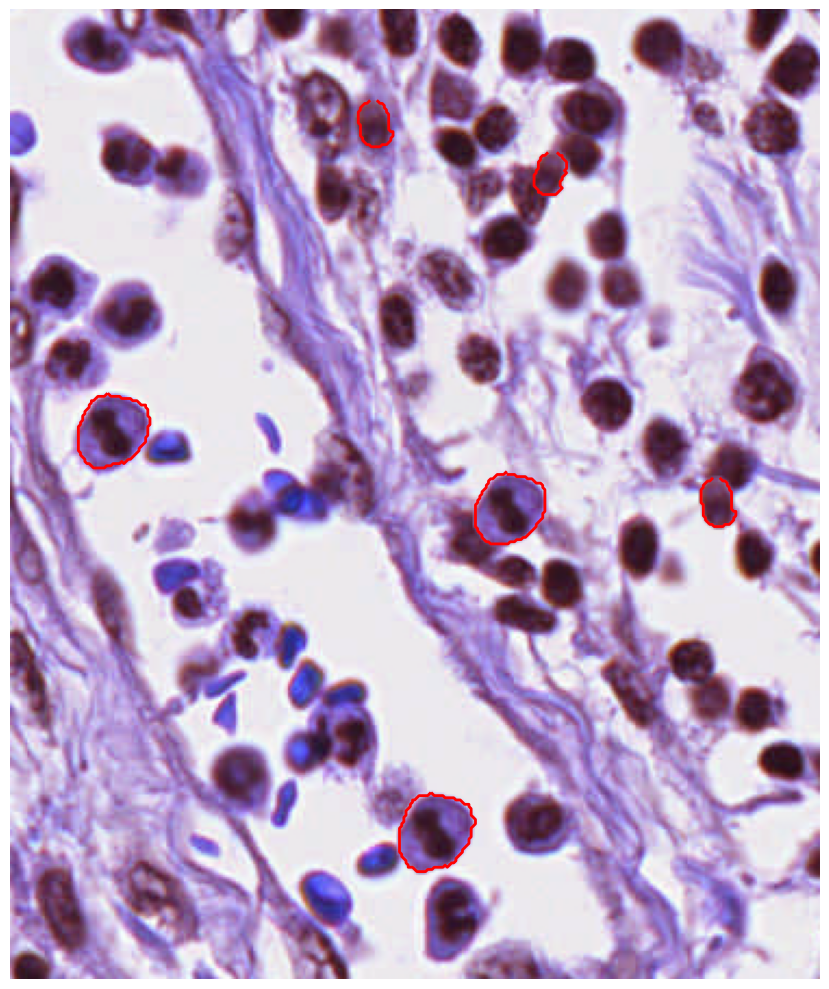

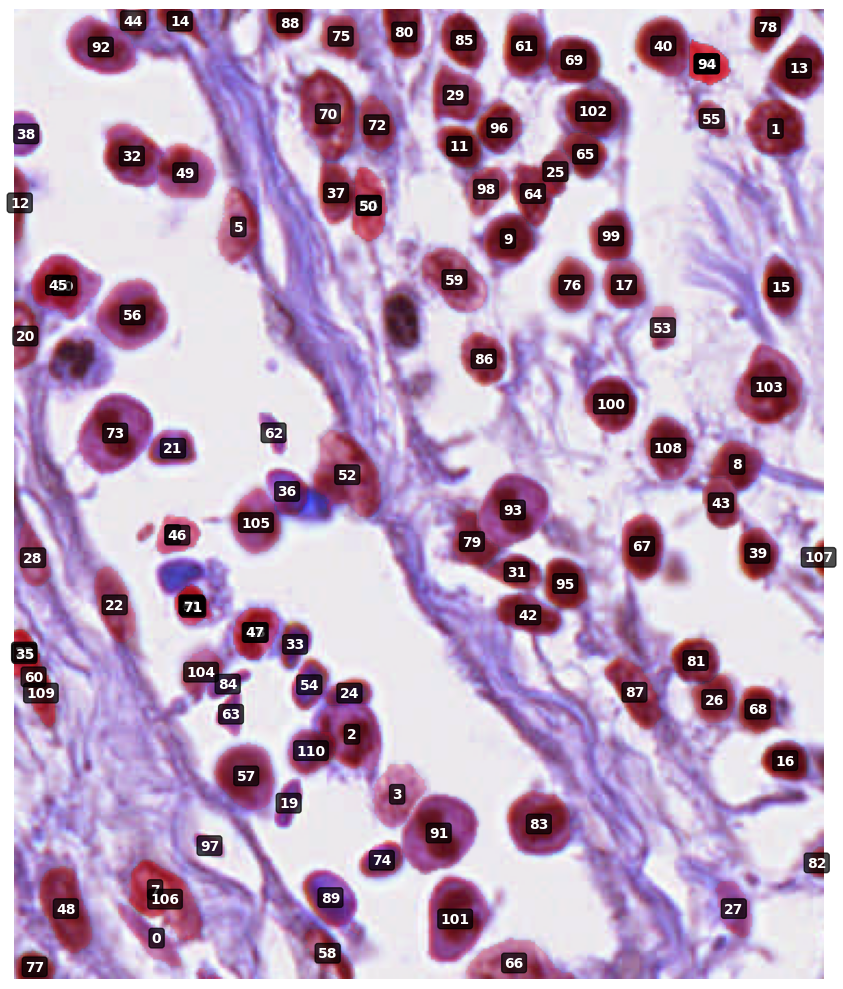

In [14]:
display_image_with_mask(
    sample_x.image,
    sample_x.ground_truth_mask,
    # opacity=0.0,
    # only_outline=False
)
display_image_with_mask(
    sample_x.image,
    sample_x.sam3_results.masks,
    show_labels=True,
    opacity=0.2,
    only_outline=False

)

In [ ]:
def get_hu_moments(sample: Sample):
    masks = sample.sam3_results.masks
    hu_moments_list = []
    for i in range(masks.shape[0]):
        mask_np = masks[i].astype(np.uint8)  # Get single 2D mask and convert to uint8
        moments = cv2.moments(mask_np)
        hu = cv2.HuMoments(moments).flatten()
        hu_log = np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
        hu_moments_list.append(np.round(hu_log, 4))
    return hu_moments_list

def add_hu_moments(sample: list[Sample]) -> list[Sample]:
    for s in sample:
        s.hu_moments = get_hu_moments(s)  # pyright: ignore[reportAttributeAccessIssue]
    return sample

def get_all_hu_moments(samples: list[Sample]):
    # for sample in samples:
    #     yield get_hu_moments(sample)
    return [get_hu_moments(sample) for sample in samples]

train_samples_with_hu_moments = add_hu_moments(train_samples_with_sam3)


def test_hu_moments(hu_moment1, hu_moment2):
    return np.linalg.norm(hu_moment1 - hu_moment2)

def find_closest_by_hu_moments(hu_moments: np.ndarray, obj_idx: int, k: int = 10) -> list[tuple[int, float]]:
    """Find k closest objects to obj_idx by Hu moment distance. Returns [(idx, distance), ...]"""
    distances = [(i, np.linalg.norm(hu_moments[obj_idx] - hu_moments[i]))
                 for i in range(len(hu_moments)) if i != obj_idx]
    distances.sort(key=lambda x: x[1])
    return distances[:k]

def measure_embedding_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

def find_closest_by_embeddings(embeddings: list, obj_idx: int, k: int = 10) -> list[tuple[int, float]]:
    """Find k closest objects to obj_idx by cosine distance. Returns [(idx, distance), ...]"""
    if embeddings[obj_idx] is None:
        return []
    distances = []
    for i in range(len(embeddings)):
        if i == obj_idx or embeddings[i] is None:
            continue
        sim = np.dot(embeddings[obj_idx], embeddings[i]) / (np.linalg.norm(embeddings[obj_idx]) * np.linalg.norm(embeddings[i]))
        distances.append((i, 1 - sim))
    distances.sort(key=lambda x: x[1])
    return distances[:k]

sample_x = train_samples_with_hu_moments[num]

In [ ]:
def get_model_scores(sample: Sample,):
    forgery_groups = get_forgery_index_groups(sample.ground_truth_mask, sample.sam3_results)
    all_hu_moments = get_hu_moments(sample)
    model_scores = []
    for forgery_group in forgery_groups:
        group_scores = []
        gt_index = forgery_group[0]
        gt_hu_moments = all_hu_moments[gt_index]
        for i, hu_moments in enumerate(all_hu_moments):
            hu_score = test_hu_moments(gt_hu_moments, hu_moments)
            group_scores.append((i, hu_score, i in forgery_group))
        model_scores.append(sorted(group_scores, key=lambda x: x[1])[:10])
    return model_scores




In [15]:
query_obj = 72

Hu moments - 10 closest to object 72:
  3: 0.7468
  15: 0.7707
  92: 0.8863
  54: 0.9938
  75: 1.1001
  31: 1.2383
  25: 1.2668
  57: 1.3124
  30: 1.3384
  13: 1.3943


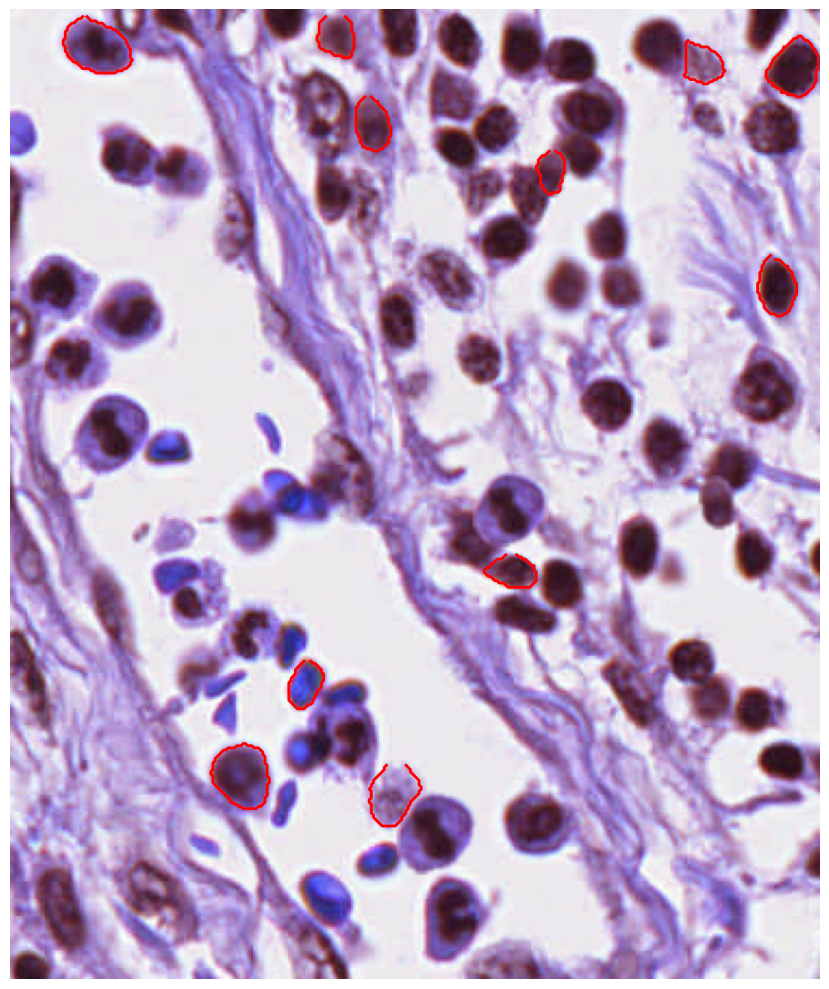

In [18]:
# Find 10 closest objects to object 0 by Hu moments
closest = find_closest_by_hu_moments(sample_x.hu_moments, query_obj)
print(f"Hu moments - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

# Display query object and its closest matches
masks = sample_x.sam3_results.masks
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))

In [19]:
# Load CLIP Base
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Get CLIP embeddings for each object
clip_embeddings = []
for hu_moments in sample_x.sam3_results.masks:
    crop = get_masked_crop(sample_x.image, hu_moments)
    if crop is None:
        clip_embeddings.append(None)
        continue
    inputs = clip_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
    clip_embeddings.append(emb[0].cpu().numpy())

# Free CLIP Base
del clip_model, clip_processor
torch.cuda.empty_cache()

Loading weights: 100%|██████████| 398/398 [00:00<00:00, 727.23it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [20]:
# Find 10 closest objects by CLIP
closest = find_closest_by_embeddings(clip_embeddings, query_obj)
print(f"CLIP - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))

CLIP - 10 closest to object 72:
  43: 0.0141
  61: 0.0174
  35: 0.0179
  15: 0.0185
  23: 0.0187
  25: 0.0193
  37: 0.0199
  68: 0.0207
  67: 0.0209
  28: 0.0221


TypeError: 'Sam3Results' object is not subscriptable

In [16]:
# Load CLIP Large
clip_large_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_large_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Get CLIP Large embeddings for each object
def get_clip_large_embeddings(sample: Sample, clip_large_model: CLIPModel, clip_large_processor: CLIPProcessor):
    clip_large_embeddings = []
    for mask in sample.sam3_results.masks:
        crop = get_masked_crop(sample.image, mask)
        if crop is None:
            clip_large_embeddings.append(None)
            continue
        inputs = clip_large_processor(images=crop, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clip_large_model.get_image_features(**inputs)
            clip_large_embeddings.append(emb[0].cpu().numpy())
            # Explicitly delete tensors to free GPU memory
            del inputs, emb
    return clip_large_embeddings

# Free CLIP Large
# del clip_large_model, clip_large_processor
# torch.cuda.empty_cache()

# # Find 10 closest objects by CLIP Large
# closest = find_closest_by_embeddings(clip_large_embeddings, query_obj)
# print(f"CLIP Large - 10 closest to object {query_obj}:")
# for idx, dist in closest:
#     print(f"  {idx}: {dist:.4f}")

# masks = sample_x.sam3_results["masks"].cpu().numpy()
# display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))


Loading weights: 100%|██████████| 590/590 [00:00<00:00, 616.38it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [17]:
# def get_embedding_model_scores(sample: Sample,):
#     forgery_groups = get_forgery_index_groups(sample.ground_truth_mask, sample.sam3_results)
#     all_embeddings = get_clip_large_embeddings(sample, clip_large_model, clip_large_processor)
#     model_scores = []
#     for forgery_group in forgery_groups:
#         group_scores = []
#         gt_index = forgery_group[0]
#         gt_embedding = all_embeddings[gt_index]
#         for i, embedding in enumerate(all_embeddings):
#             embedding_score = measure_embedding_similarity(gt_embedding, embedding)
#             group_scores.append((i, embedding_score, i in forgery_group))
#         model_scores.append(sorted(group_scores, key=lambda x: -x[1])[:20])
#     return model_scores
def compute_embedding_matrix_for_clustering(sample: Sample):
    """
    Returns:
        embeddings: np.ndarray of shape (N, embedding_dim) - raw embeddings
        similarity_matrix: np.ndarray of shape (N, N) - pairwise cosine similarities
        valid_indices: list of indices that have valid embeddings (not None)
    """
    forgery_groups = get_forgery_index_groups(sample.ground_truth_mask, sample.sam3_results)
    all_embeddings = get_clip_large_embeddings(sample, clip_large_model, clip_large_processor)

    # Stack into (N, D) matrix
    embeddings = np.stack(all_embeddings)  # shape: (N, embedding_dim)

    # Normalize for cosine similarity
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized = embeddings / norms

    # Compute full similarity matrix: (N, N)
    similarity_matrix = normalized @ normalized.T

    return embeddings, similarity_matrix, forgery_groups


In [19]:
import json
all_scores = []
for sample in train_samples_with_sam3:
    if sample.ground_truth_mask is None:
        continue
    # save to file  a list of lists
    try:
        all_scores.append(compute_embedding_matrix_for_clustering(sample))
    except Exception as e:
        print(f"Error processing sample {sample.file_name}: {e}")
        continue

The channel dimension is ambiguous. Got image shape (1, 160, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


Error processing sample 63312.png: mean must have 1 elements if it is an iterable, got 3
Error processing sample 31168.png: need at least one array to stack


The channel dimension is ambiguous. Got image shape (3, 20, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 23, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 14, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


Error processing sample 42287.png: need at least one array to stack
Error processing sample 22834.png: need at least one array to stack
Error processing sample 13989.png: need at least one array to stack


The channel dimension is ambiguous. Got image shape (3, 13, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 15, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


Error processing sample 37321.png: need at least one array to stack


The channel dimension is ambiguous. Got image shape (3, 18, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 5, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


Error processing sample 13785.png: all input arrays must have the same shape


The channel dimension is ambiguous. Got image shape (3, 5, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 8, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 7, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.
The channel dimension is ambiguous. Got image shape (3, 53, 3). 

In [20]:
# save all_scores to pickle file
import pickle
with open("all_scores.pkl", "wb") as f:
    pickle.dump(all_scores, f)


In [ ]:
# Convert numpy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_to_serializable(item) for item in obj)
    return obj

serializable_scores = convert_to_serializable(all_scores)

with open(f"embedding_model_scores.json", "w") as f:
    json.dump(serializable_scores, f, indent=2)

In [ ]:
# Load DINOv2
dino_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dino_model = AutoModel.from_pretrained("facebook/dinov2-base").to(device)

# Get DINOv2 embeddings for each object
dino_embeddings = []
for hu_moments in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, hu_moments)
    if crop is None:
        dino_embeddings.append(None)
        continue
    inputs = dino_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = dino_model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1)[0]  # Pool over patches
    dino_embeddings.append(emb.cpu().numpy())

# Free DINOv2
del dino_model, dino_processor
torch.cuda.empty_cache()

# Find 10 closest objects by DINOv2
closest = find_closest_by_embeddings(dino_embeddings, query_obj)
print(f"DINOv2 - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))


In [ ]:
# Load SigLIP
siglip_processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
siglip_model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384").to(device)

# Get SigLIP embeddings for each object
siglip_embeddings = []
for hu_moments in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, hu_moments)
    if crop is None:
        siglip_embeddings.append(None)
        continue
    inputs = siglip_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = siglip_model.get_image_features(**inputs)
    siglip_embeddings.append(outputs[0].cpu().numpy())

# Free SigLIP
del siglip_model, siglip_processor
torch.cuda.empty_cache()

# Find 10 closest objects by SigLIP
closest = find_closest_by_embeddings(siglip_embeddings, query_obj)
print(f"SigLIP - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))


In [ ]:
# Load EVA-CLIP
eva_model, _, eva_preprocess = open_clip.create_model_and_transforms('EVA02-B-16', pretrained='merged2b_s8b_b131k')
eva_model = eva_model.to(device)

# Get EVA-CLIP embeddings for each object
eva_embeddings = []
for hu_moments in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, hu_moments)
    if crop is None:
        eva_embeddings.append(None)
        continue
    img_tensor = eva_preprocess(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = eva_model.encode_image(img_tensor)
    eva_embeddings.append(emb[0].cpu().numpy())

# Free EVA-CLIP
del eva_model, eva_preprocess
torch.cuda.empty_cache()

# Find 10 closest objects by EVA-CLIP
closest = find_closest_by_embeddings(eva_embeddings, query_obj)
print(f"EVA-CLIP - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))
